<AxesSubplot:title={'center':'Covid'}, xlabel='State'>

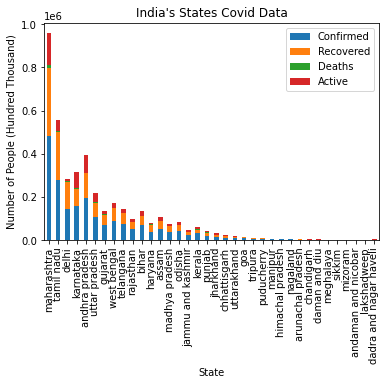

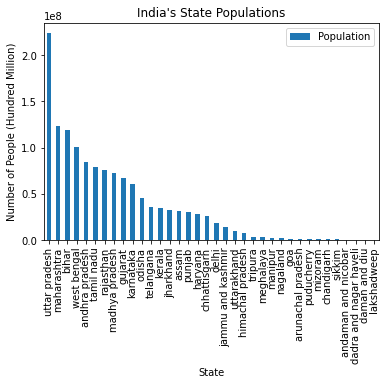

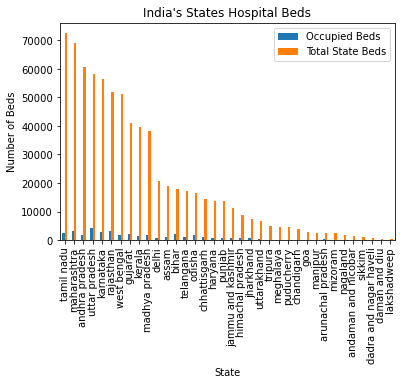

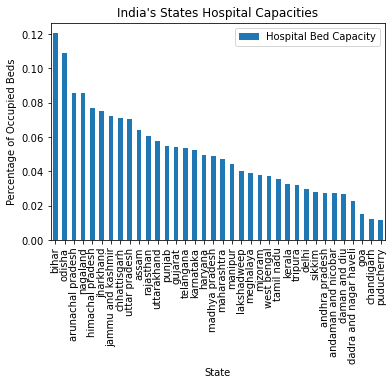

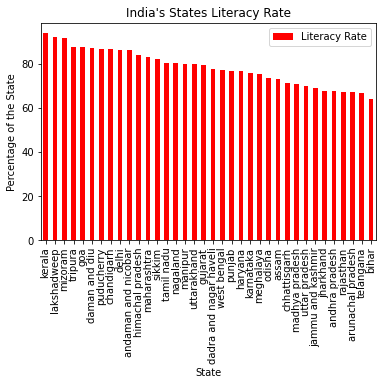

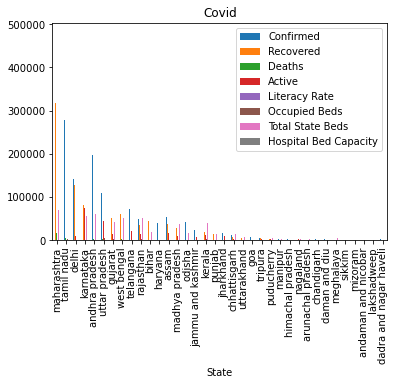

In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

#Getting all the data.
covid = pd.read_csv('state_level_latest.csv')
literacy = pd.read_csv('India Literacy rate.csv')
hosp_beds = pd.read_csv('Hospitals_and_Beds_statewise.csv')
population = pd.read_csv('population.csv',delimiter=",")


#Removing columns from the data sets.
hosp_beds=hosp_beds.drop(['PHC','CHC','SDH','DH'],axis=1)
covid = covid.drop(['Migrated_Other','State_code','Delta_Confirmed','Delta_Deaths',
                    'Last_Updated_Time',
                    'Delta_Recovered','State_Notes'],axis=1)

#Naming the State and total bed columns.
hosp_beds.rename(columns={'Unnamed: 0':'State'}, inplace=True)
hosp_beds.rename(columns={'Unnamed: 6':'Total State Beds'}, inplace=True)
hosp_beds.rename(columns={'Total':'Occupied Beds'}, inplace=True)
population.rename(columns={'State ':'State'}, inplace=True)


literacy.rename(columns={'Literacyrate':'Literacy Rate'}, inplace=True)

#Removing the all India as we are focused on the states.
all_drop = hosp_beds[(hosp_beds.State=='All India')].index
hosp_beds= hosp_beds.drop(all_drop)

#Making all the State names lowercase.
hosp_beds['State'] = hosp_beds['State'].str.lower()
literacy['State'] = literacy['State'].str.lower()
population['State'] = population['State'].str.lower()
covid['State'] = covid['State'].str.lower()

#Removing specific states from the data.
all_drop= covid[(covid.State =='state unassigned')].index
covid= covid.drop(all_drop)
all_drop= covid[(covid.State =='total')].index
covid= covid.drop(all_drop)
all_drop = covid[(covid.State=='ladakh')].index
covid= covid.drop(all_drop)


covid = covid.replace({'dadra and nagar haveli and daman and diu':'daman and diu'})
i= covid[(covid['State'] =='daman and diu')].index
val = covid.loc[i]

val=val.replace('daman and diu','dadra and nagar haveli')
covid = covid.append(val)

covid = covid.replace({'andaman and nicobar islands':'andaman and nicobar'})


#Replacing '&' with 'and' in the hospital names.
hosp_beds['State'] = hosp_beds['State'].str.replace('&','and')

#Adjusting the literacy State names to the proper ones. 
literacy =literacy.replace('chattisgarh','chhattisgarh')
literacy =literacy.replace('puchucherry','puducherry')
literacy = literacy.replace('uttarkhand','uttarakhand')
literacy = literacy.replace('dadra and nagar island','dadra and nagar haveli')
literacy = literacy.replace('tamilnadu','tamil nadu')

#Adjusting the population State names with the proper ones.
population =population.replace('chattisgarh','chhattisgarh')
population =population.replace('puchucherry','puducherry')

population =population.replace('uttarkhand','uttarakhand')
population =population.replace('dadra and nagar island','dadra and nagar haveli')
population = population.replace('tamilnadu','tamil nadu')

#Adjusting the hospital names.
hosp_beds = hosp_beds.replace('andaman and nicobar islands','andaman and nicobar')

hosp_names = hosp_beds['State'].tolist()
lit_names =literacy['State'].tolist()
covid_names = covid['State'].tolist()
pop_names =population['State'].tolist()


count=0
#Making sure the names are all the same in both datasets.
#print(set(covid_names)- set(hosp_names))
#print(set(pop_names)-set(hosp_names))
for i in lit_names:
    if(i in hosp_names):
        count+=1
    else:
        print("ERROR not the same.")


#A function that takes a dataset and removes all the outliers.
def outlier(data):
    #Getting the 1st and third percentile.
    q3 =data.quantile(0.75)
    q1 =data.quantile(0.25)

    #Calculating the interquartile range.
    IQR = q3-q1

    lower = ((q1 - 1.5 * IQR))
    upper =((q3 + 1.5 * IQR))
    #Removing outliers from the data.
    data = data[~((data < lower)) 
                               |(data > upper).any(axis=1)]
    return data


#Plotting the India Covid data with Confirmed, Recovered, Deaths and Active columns.
covid=covid.set_index('State')
covid = outlier(covid)
covid.plot(kind='bar', stacked=True, 
           title="India's States Covid Data",
          ylabel= "Number of People (Hundred Thousand)")
#print(covid.describe())

#Plotting the population in a sorted order.
population = population.set_index('State')
population.sort_values(ascending=False,
                      by=['Population']).plot(kind='bar', 
                                              title="India's State Populations",
                                             ylabel="Number of People (Hundred Million)")

#Changing the type to numeric.
hosp_beds['Total State Beds']=hosp_beds['Total State Beds'].astype(int)
hosp_beds['Occupied Beds']=hosp_beds['Occupied Beds'].astype(int)

hosp_beds=hosp_beds.set_index('State')
hosp_beds = outlier(hosp_beds)

#Plotting the total state beds and the occupied beds in a sorted order.
hosp_beds.sort_values(ascending=False,
                      by=['Total State Beds']).plot(kind='bar',
                                                   title="India's States Hospital Beds",
                                                   ylabel="Number of Beds")
#print(hosp_beds.describe(include='all'))


#Column transformation divding the occupied beds by the total beds to get the current percent capacity.
hosp_beds['Hospital Bed Capacity'] = hosp_beds['Occupied Beds']/hosp_beds['Total State Beds']   
perc_beds= hosp_beds.copy()
perc_beds = perc_beds.drop(['Total State Beds','Occupied Beds'],axis=1)

#Displaying a snapshot of the current occupancy compared to total number of beds.
perc_beds.sort_values(ascending=False,
                      by=['Hospital Bed Capacity']).plot(kind ='bar',
                                                 ylabel="Percentage of Occupied Beds",
                                                 title="India's States Hospital Capacities")
#Rotating the x-axis labels 90 degrees
plt.xticks(rotation=90)

#Displaying the literacy data as a bar graph.
literacy=literacy.set_index('State')
literacy = outlier(literacy)
literacy.sort_values(ascending=False,
                      by=['Literacy Rate']).plot(kind='bar',
                                                 color="r", 
                                                 title = "India's States Literacy Rate",
                                                 ylabel="Percentage of the State")
#print(literacy.describe())


        
#Merging the data together. 
result =pd.merge(left=covid,right=literacy,left_on='State',right_on='State')
final_result =pd.merge(left=result,right=hosp_beds,left_on='State',right_on='State')

#final_result=final_result.set_index('State')
#print(final_result)
final_result.plot(kind='bar',title = 'Covid')

